In [15]:
# Code to read csv file into Colaboratory:

import os
import os.path
import numpy as np
import time
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [16]:
from fastai.vision import *
from fastai.widgets import *

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
path = Path('drive/My Drive')

In [34]:
# add all image filenames into a list
images_name = []
idx_name = []
for i in range(63):
  dir_ = str(path)+'/google_images/'+ str(i) + '/'
  try:
    image_files = os.listdir(dir_)
    images_name.append(image_files)
    idx_name.append(i)
  except: pass

In [35]:
all_images_downloaded = []
for i in range(0, len(images_name)): 
  list_within = images_name[i]
  for item in list_within: 
    all_images_downloaded.append(item)
print('total number of images =',len(all_images_downloaded))

total number of images = 50025


In [38]:
len_images_name=[]
for i in range(len(images_name)):
  len_images_name.append(len(images_name[i]))
#  print(len(images_name)):

In [39]:
df_test = pd.DataFrame({'idx':idx_name, 'names':len_images_name})
df_test.shape

(57, 2)

In [ ]:
50023-48960-332-240-122

369

In [ ]:
### Classify images into three groups
def move_to_group(lightness_small, lightness_big, class_id):
    new_directory = 'data/google_image_cnn/class_' + str(class_id) + '/'
    if not os.path.isdir(new_directory):
        os.makedirs(new_directory)
    for i in range(lightness_small, lightness_big):
        path = 'data/google_image/' + str(i) + '/'
        for f in os.listdir(path):
            copyfile(path + f, new_directory + f)

move_to_group(0, 1, 1)
move_to_group(1, 10, 2)
move_to_group(10, 64, 3)

,idx,names
0,0,48960
1,6,332
2,7,240
3,8,122
4,9,91


In [ ]:
!/drive ls

/bin/bash: /drive: No such file or directory


### Merge daytime image data with DHS

In [ ]:
features_basic = np.loadtxt(str(path)+'/google_images/google_image_features_basic.csv')

In [ ]:
# help file
def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

def get_daytime_feature(sample):
    idx, wealth, x, y = sample
    lon_idx, lat_idx = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    left_idx = lon_idx - 5
    right_idx = lon_idx + 4
    up_idx = lat_idx - 5
    low_idx = lat_idx + 4
    features_100 = []
    for i in range(left_idx, right_idx + 1):
        for j in range(up_idx, low_idx + 1):
            feature = features_basic[((features_basic[:,0]==i) & (features_basic[:,1]==j)),][:,2:]
            if len(feature) > 0:
                features_100.append(feature)
    if len(features_100) == 0:
        return np.asarray([np.nan] * 15 + [wealth]).tolist()
    else:
        features_all = np.concatenate(features_100, axis=0)
        mean_ = np.mean(features_all, axis=0).tolist()
        mean_.append(wealth)
        return mean_

In [ ]:
npzfile = np.load(str(path)+'/google_images/nightlight.npz')
top_left_x_coords = npzfile['top_left_x_coords']
top_left_y_coords = npzfile['top_left_y_coords']
bands_data = npzfile['bands_data']

In [ ]:
clusters = pd.read_csv(str(path)+'/google_images/BU_cluster_avg_asset_2010.csv')
clusters['feature'] = clusters.apply(lambda x: get_daytime_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)

data_all = clusters['feature']
data_all = np.asarray([i for i in data_all])
data_all = data_all[~np.isnan(data_all).any(axis=1)]

np.savetxt(str(path)+'/google_images/DHS_daytime.csv', data_all)

In [ ]:
data_all = np.loadtxt('intermediate_files/DHS_daytime.csv')
alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print 'R^2 of the best model: {:.3f}'.format(np.max(final))

,cluster,wlthindf,latitude,longitude,feature
0,1,0.939470,-3.368500,29.362186,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,2,-0.437740,-3.816132,29.963905,"[202.6, 202.44, 197.62, 0.24, 9.77, 11.92, 75...."
2,3,-0.356630,-2.505578,30.258659,"[208.15, 197.76, 192.77, 1.02, 5.93, 4.83, 86...."
3,4,-0.444145,-3.428142,30.257026,"[208.1888888888889, 209.6888888888889, 205.166..."
4,5,-0.498495,-3.758130,30.310477,"[212.18, 205.7, 199.05, 0.15, 1.72, 1.16, 95.3..."
...,...,...,...,...,...
371,372,-0.535460,-2.701994,29.963929,"[204.38, 207.36, 206.19, 0.21, 10.73, 12.47, 7..."
372,373,-0.476550,-3.338466,30.614601,"[218.7, 216.53333333333333, 212.63333333333333..."
373,374,-0.420865,-3.582035,29.945715,"[204.66, 201.4, 195.59, 0.0, 2.46, 0.65, 73.00..."
374,375,-0.434410,-3.419263,29.492293,"[216.21, 217.92, 209.33, 0.85, 9.06, 6.42, 75...."


Image Preprocess

In [ ]:
image_path = 'drive/My Drive/google_image_class/'
def plt_display(image, title):
  fig = plt.figure()
  a = fig.add_subplot(1, 1, 1)
  imgplot = plt.imshow(image)
  a.set_title(title)

In [65]:
path_1 = Path('drive/My Drive/google_image_class/class_1')
np.random.seed(42)
data_1 = ImageDataBunch.from_folder(path_1, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

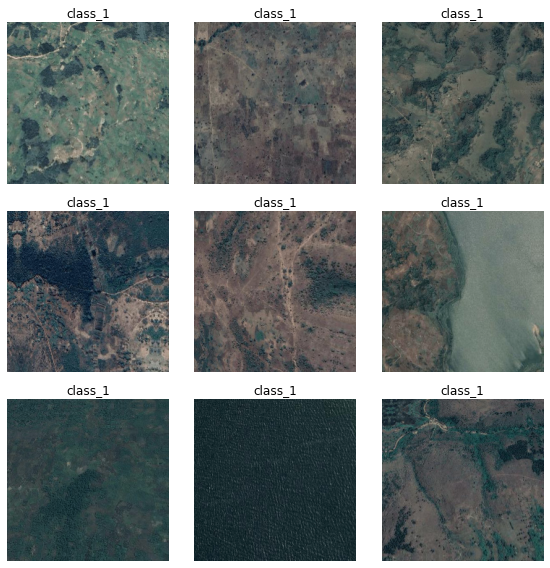

In [66]:
data_1.show_batch(rows=3, figsize=(8,8))

In [67]:
path_2 = Path('drive/My Drive/google_image_class/class_2')
np.random.seed(42)
data_2 = ImageDataBunch.from_folder(path_2, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)


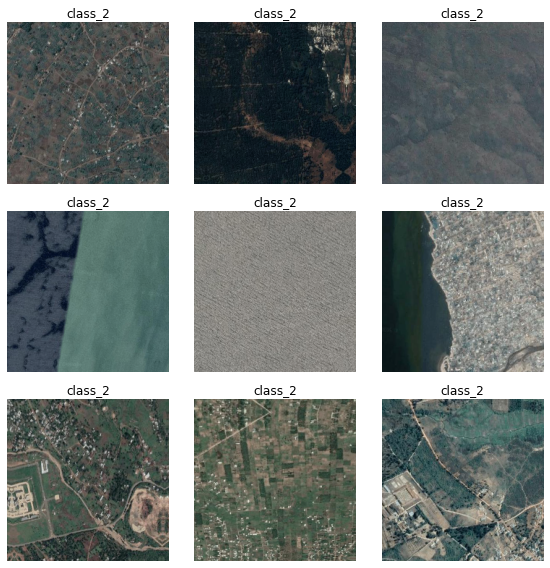

In [68]:
data_2.show_batch(rows=3, figsize=(8,8))

In [73]:
path_3 = Path('drive/My Drive/google_image_class/class_3')
np.random.seed(42)
data_3 = ImageDataBunch.from_folder(path_3, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)


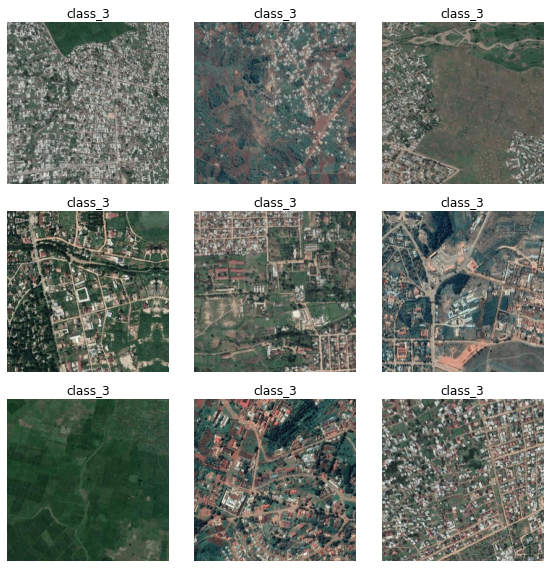

In [74]:
data_3.show_batch(rows=3, figsize=(8,8))

In [37]:
data_transforms = transforms.Compose([
                    transforms.CenterCrop(224),
                    transforms.ToTensor()])

image_datasets = datasets.ImageFolder(root= 'drive/My Drive/google_images/class_1', transform=data_transforms)

NameError: ignored

In [35]:
!ls 'drive/My Drive/google_images/class_1'

25080_9277.jpg	25118_9500.jpg	25157_9489.jpg	25196_9385.jpg	25234_9391.jpg
25080_9278.jpg	25118_9501.jpg	25157_9490.jpg	25196_9386.jpg	25234_9392.jpg
25080_9279.jpg	25118_9502.jpg	25157_9491.jpg	25196_9387.jpg	25234_9393.jpg
25080_9280.jpg	25118_9503.jpg	25157_9492.jpg	25196_9388.jpg	25234_9394.jpg
25080_9281.jpg	25118_9504.jpg	25157_9493.jpg	25196_9389.jpg	25234_9395.jpg
25080_9282.jpg	25118_9505.jpg	25157_9494.jpg	25196_9390.jpg	25234_9396.jpg
25080_9283.jpg	25118_9506.jpg	25157_9495.jpg	25196_9391.jpg	25234_9397.jpg
25080_9284.jpg	25118_9507.jpg	25157_9496.jpg	25196_9392.jpg	25234_9398.jpg
25080_9285.jpg	25118_9508.jpg	25157_9497.jpg	25196_9393.jpg	25234_9399.jpg
25080_9286.jpg	25118_9509.jpg	25157_9498.jpg	25196_9394.jpg	25234_9400.jpg
25080_9287.jpg	25118_9510.jpg	25157_9499.jpg	25196_9395.jpg	25234_9401.jpg
25080_9288.jpg	25118_9511.jpg	25157_9500.jpg	25196_9396.jpg	25234_9402.jpg
25080_9289.jpg	25118_9512.jpg	25157_9501.jpg	25196_9397.jpg	25234_9403.jpg
25080_9290.jpg	25118_9513

# New Section